In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt




df = pd.read_csv('oasis_longitudinal.csv')

#print("Loading dataset")

#fill null value with their column mean and median
df["SES"].fillna(df["SES"].median(), inplace=True)
df["MMSE"].fillna(df["MMSE"].mean(), inplace=True)




ex_df = df.loc[df['Visit'] == 1]


ex_df['Group'] = ex_df['Group'].replace(['Converted'], ['Demented'])
df['Group'] = df['Group'].replace(['Converted'], ['Demented'])
sns.countplot(x='Group', data=ex_df)


#convet the charecter data into numeric
group_map = {"Demented": 1, "Nondemented": 0}

df['Group'] = df['Group'].map(group_map)
df['M/F'] = df['M/F'].replace(['F','M'], [0,1])



# Encode columns into numeric
from sklearn.preprocessing import LabelEncoder
for column in df.columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])



from sklearn.model_selection import train_test_split

feature_col_names = ["M/F", "Age", "EDUC", "SES", "MMSE", "eTIV", "nWBV", "ASF"]
predicted_class_names = ['Group']

X = df[feature_col_names].values
y = df[predicted_class_names].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


from sklearn import metrics
def plot_confusion_metrix(y_test,model_test):
    cm = metrics.confusion_matrix(y_test, model_test)
    plt.figure(1)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Nondemented','Demented']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()


# In[ ]:


from sklearn.metrics import roc_curve, auc
def report_performance(model):

    model_test = model.predict(X_test)

    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(y_test, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(y_test, model_test))
    #cm = metrics.confusion_matrix(y_test, model_test)
    plot_confusion_metrix(y_test, model_test)

total_fpr = {}
total_tpr = {}
def roc_curves(model):
    predictions_test = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(predictions_test,y_test)
    roc_auc = auc(fpr, tpr)
    total_fpr[str((str(model).split('(')[0]))] = fpr
    total_tpr[str((str(model).split('(')[0]))] = tpr
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()


total_accuracy = {}
def accuracy(model):
    pred = model.predict(X_test)
    accu = metrics.accuracy_score(y_test,pred)
    print("\nAcuuracy Of the Model: ",accu,"\n\n")
    total_accuracy[str((str(model).split('(')[0]))] = accu



from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
#from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
#from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB


# In[ ]:
print("\n\n\nSUPPORT VECTOR CLASSIFIER")

svm = SVC(kernel="linear", C=0.1,random_state=0)
svm.fit(X_train, y_train.ravel())
report_performance(svm) 
roc_curves(svm)
accuracy(svm)


# In[ ]:
print("\n\n\n RANDOM FOREST")

rfc=RandomForestClassifier(criterion='gini',max_depth=8,max_features='auto',n_estimators=200)

param_grid = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini']
}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring = 'roc_auc')
rfc.fit(X_train, y_train.ravel())
#print("Best parameters set found on development set:")
#print(rfc.best_params_)
y_pred=rfc.predict(X_test)


#print(y_train)
report_performance(rfc) 
roc_curves(rfc)
accuracy(rfc)




# In[ ]:
print("\n\n\n DECISION TREE CLASSIFIERS")
clf_dtc = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=0)
clf_dtc.fit(X_train, y_train.ravel())
report_performance(clf_dtc) 
roc_curves(clf_dtc)
accuracy(clf_dtc)
#importances = clf.feature_importances_





# In[ ]:


from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection


# In[ ]:

'''print("\n\n\n VOTING CLASSIFIERS")
vote_est = [('etc',ensemble.ExtraTreesClassifier()),
            ('gb',GradientBoostingClassifier()),
            ('abc',AdaBoostClassifier()),
    ('rfc', ensemble.RandomForestClassifier(criterion='gini', max_depth=8, max_features='auto', n_estimators=200)),
    #('svc', svm.SVC(probability=True)),
    #('xgb', XGBClassifier()),
            #('lbgm',LGBMClassifier())
           ]


vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X_train, y_train.ravel())
vote_hard.fit(X_train, y_train.ravel())
report_performance(vote_hard) 
roc_curves(vote_hard)
accuracy(vote_hard)
pred = vote_hard.predict(X_test)
accu = metrics.accuracy_score(y_test,pred)
#print("\nAcuuracy Of the Model: ",accu,"\n\n")

'''
# In[ ]:


'''clfs =[GradientBoostingClassifier()]
for model in clfs:
    print("\n\n\n",str(model).split('(')[0],": ")
    model.fit(X_train,y_train.ravel())
    X = pd.DataFrame(X_train)
    report_performance(model)
    roc_curves(model)
    accuracy(model)'''
    
    











/home/kajal/.local/lib/python3.5/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy





SUPPORT VECTOR CLASSIFIER


Confusion Matrix:
[[46  6]
 [19 41]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.71      0.88      0.79        52
           1       0.87      0.68      0.77        60

   micro avg       0.78      0.78      0.78       112
   macro avg       0.79      0.78      0.78       112
weighted avg       0.80      0.78      0.78       112



<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>


Acuuracy Of the Model:  0.7767857142857143 





 RANDOM FOREST


Confusion Matrix:
[[46  6]
 [12 48]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.79      0.88      0.84        52
           1       0.89      0.80      0.84        60

   micro avg       0.84      0.84      0.84       112
   macro avg       0.84      0.84      0.84       112
weighted avg       0.84      0.84      0.84       112



<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>


Acuuracy Of the Model:  0.8392857142857143 





 DECISION TREE CLASSIFIERS


Confusion Matrix:
[[43  9]
 [14 46]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.75      0.83      0.79        52
           1       0.84      0.77      0.80        60

   micro avg       0.79      0.79      0.79       112
   macro avg       0.80      0.80      0.79       112
weighted avg       0.80      0.79      0.79       112



<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>


Acuuracy Of the Model:  0.7946428571428571 




'clfs =[GradientBoostingClassifier()]\nfor model in clfs:\n    print("\n\n\n",str(model).split(\'(\')[0],": ")\n    model.fit(X_train,y_train.ravel())\n    X = pd.DataFrame(X_train)\n    report_performance(model)\n    roc_curves(model)\n    accuracy(model)'

Text(0, 0.5, 'Accuracy')

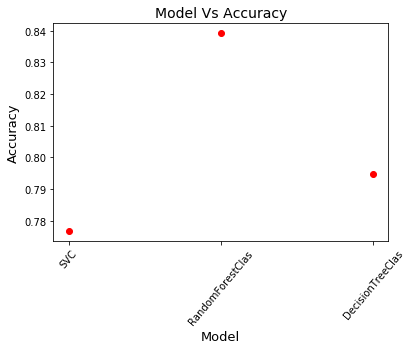

In [2]:
data = total_accuracy.values()
labels = total_accuracy.keys()

plt.plot([i for i, e in enumerate(data)], data, 'ro'); plt.xticks([i for i, e in enumerate(labels)], [l[0:16] for l in labels])
plt.title("Model Vs Accuracy",fontsize = 14)
plt.xlabel('Model',fontsize = 13)
plt.xticks(rotation = 50)
plt.ylabel('Accuracy',fontsize = 13)




